<a href="https://colab.research.google.com/github/secutron/TesTime/blob/main/diffusers/test_controlnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

논문: [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

참조: 
- [controlnet](https://github.com/lllyasviel/ControlNet) - 상기 논문의 오피셜 구현
- [controlnet_aux](https://github.com/patrickvonplaten/controlnet_aux) - 컨트롤넷 annotator의 pypi 구현

In [1]:
!nvidia-smi

Tue Jun  6 11:57:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q controlnet_aux
#!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q diffusers transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.1 MB/s eta 0:00:00


###입력 이미지 선택
- /content/controlnet_aux/datasets/input/input 에 파일 업로드한다.

Image successfully uploaded:


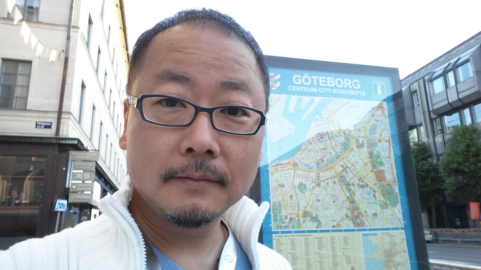

In [52]:
import os
import shutil
import imghdr
from google.colab import files
from pathlib import Path
from IPython.display import clear_output
from PIL import Image
from torchvision.transforms import Resize

def display_image(img):
  w, h = img.size
  if max(w, h) > 480:
    img = Resize(480, max_size=481)(img)
  display(img)

def process_upload(uploaded, data_path):
  if len(uploaded.keys()) > 1:
    clear_output(wait=True)
    for fn in uploaded.keys():
      os.remove(fn)
    print("Please choose 1 file!")
  else:
    fn = list(uploaded.keys())[0]
    if imghdr.what(fn) is None:
      clear_output(wait=True)
      print("Please upload a valid image file")
      os.remove(fn)
    else:
      dest_path = f"{data_path}/{fn}"
      shutil.move(fn, dest_path)
      clear_output(wait=True)
      print("Image successfully uploaded:")
      uploaded_image = Image.open(dest_path)
      display_image(uploaded_image)


!mkdir /content/controlnet_aux
os.chdir("/content/controlnet_aux")

DATAROOT = "./datasets/input"
path_dataroot = Path(DATAROOT)
if os.path.exists(path_dataroot):
  shutil.rmtree(path_dataroot)

path_input = Path(f"{DATAROOT}/input")
path_input.mkdir(parents=True, exist_ok=True)

shutil.rmtree(path_input)
path_input.mkdir(parents=True)
uploaded = files.upload()
process_upload(uploaded, f"{DATAROOT}/input")

### 업로드된 이미지에 접근

In [53]:
from io import BytesIO

last_uploaded = list(uploaded.keys())[-1]
im = Image.open(BytesIO(uploaded[last_uploaded]))
w, h = im.size
print(f"{w}, {h}")
if max(w, h) > 512:
    im = Resize(512, max_size=513)(im)
w, h = im.size
print(f"{w}, {h}")

1920, 1080
513, 288


### controlnet_aux 처리

In [54]:
from controlnet_aux.processor import Processor

# as of 230606, options are:
'''
MODELS = {
    # checkpoint models
    'hed': {'class': HEDdetector, 'checkpoint': True},
    'midas': {'class': MidasDetector, 'checkpoint': True},
    'mlsd': {'class': MLSDdetector, 'checkpoint': True},
    'openpose': {'class': OpenposeDetector, 'checkpoint': True},
    'pidinet': {'class': PidiNetDetector, 'checkpoint': True},
    'normalbae': {'class': NormalBaeDetector, 'checkpoint': True},
    'lineart': {'class': LineartDetector, 'checkpoint': True},
    'lineart_coarse': {'class': LineartDetector, 'checkpoint': True},
    'lineart_anime': {'class': LineartAnimeDetector, 'checkpoint': True},
    'zoe': {'class': ZoeDetector, 'checkpoint': True}, 
    # instantiate
    'content_shuffle': {'class': ContentShuffleDetector, 'checkpoint': False},
    'mediapipe_face': {'class': MediapipeFaceDetector, 'checkpoint': False},
    'canny': {'class': CannyDetector, 'checkpoint': False},
}
'''

processor_id = 'canny'
processor = Processor(processor_id)

processed_image = processor(im)

Loading canny processor


### 처리된 결과 확인

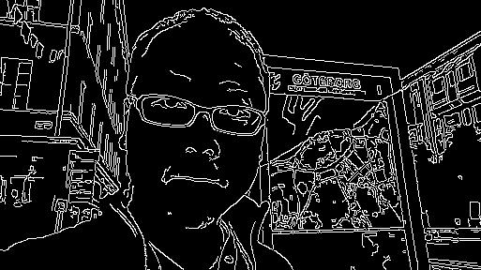

In [55]:
data_io = BytesIO(processed_image)
img_pil = Image.open(data_io)
display_image(img_pil)

### controlnet

In [56]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### 스케쥴러

In [57]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### cpu 오프로딩

In [58]:
pipe.enable_model_cpu_offload()

### xformer acceleration

In [59]:
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/20 [00:00<?, ?it/s]

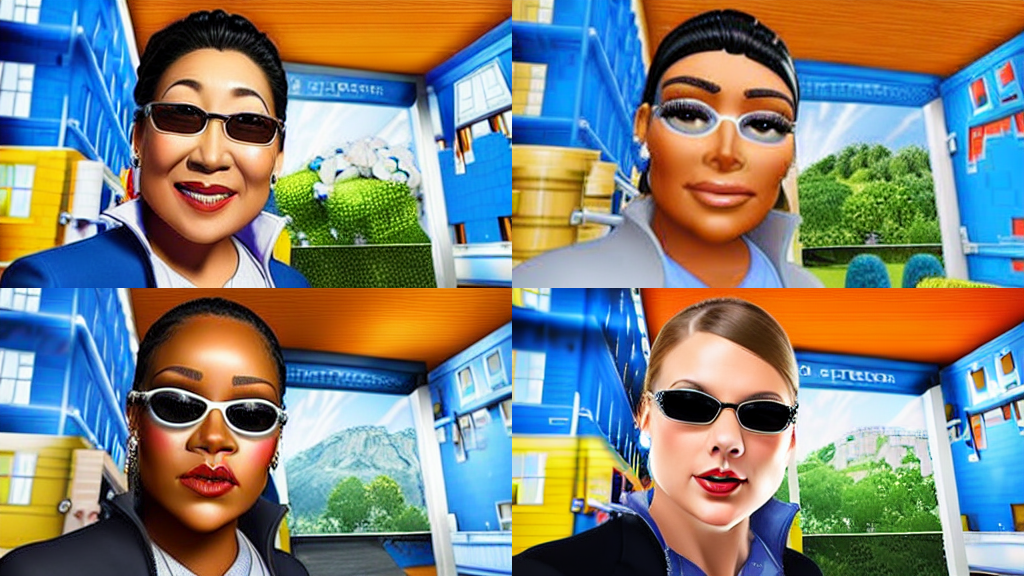

In [64]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    img_pil,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 2, 2)

In [61]:
model_id = "sd-dreambooth-library/mr-potato-head"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

unet/diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [67]:
generator = torch.manual_seed(2)
prompt = "a photo of sks mr potato head, best quality, extremely detailed"
output = pipe(
    prompt,
    img_pil,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
    num_inference_steps=20,
)

  0%|          | 0/20 [00:00<?, ?it/s]

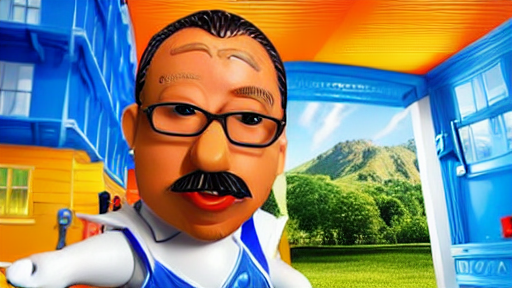

In [68]:
output.images[0]